In [35]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving X_TWO_JOINTS.csv to X_TWO_JOINTS.csv
User uploaded file "X_TWO_JOINTS.csv" with length 1527798 bytes


In [59]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  # plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


In [11]:
df_X = pd.read_csv('X_TWO_JOINTS.csv', header= None, usecols=[0,2], names=["X","Z"])
df_Y = pd.read_csv('Y_TWO_JOINTS.csv', header= None, names=["J1","J3"])
df_data = df_X.join(df_Y)
print(df_data)

             X         Z         J1          J3
0     0.182892  1.103669  -2.659524  -16.910634
1    -0.018991  0.840641 -78.769963 -115.164880
2    -0.786893  0.568495 -91.302315  -18.153684
3     0.350853  0.842898 -24.786045  -88.304229
4     0.014872  1.059766 -41.132881  -61.260355
...        ...       ...        ...         ...
9995  0.636020  0.261123  40.104177  -80.381565
9996  0.637171  0.307646  35.712157  -80.978438
9997  0.210339  1.076435 -12.282699  -37.298402
9998 -0.560832  0.924573 -54.132491   -7.120594
9999  0.235456  0.049541  40.037619 -137.748416

[10000 rows x 4 columns]


In [17]:
train, test = train_test_split(df_data,test_size=0.3)
X_train , X_test = train[["X", "Z"]], test[["X", "Z"]]
Y_train , Y_test = train[["J1", "J3"]], test[["J1", "J3"]]
print(Y_train)

             J1          J3
7494  -4.750835 -105.984150
1376  17.243152 -110.098798
3052 -48.953049  -11.221643
9113  33.002814 -167.536935
9298 -20.899658  -96.581514
...         ...         ...
3261 -69.367140  -35.926955
6915  31.319262  -29.541602
5410 -10.345217  -46.102396
7083 -23.234650 -153.990298
3430 -50.416060 -112.560391

[7000 rows x 2 columns]


In [32]:
activation = 'sigmoid'
learning_rate = 0.001
loss = 'mean_absolute_error'
n_hidden_neurons = 64
epochs = 100

In [34]:
X_train.shape

(7000, 2)

In [66]:
model_inverse = keras.Sequential([
    InputLayer(input_shape=(X_train.shape[1])),
    Dense(n_hidden_neurons, activation=activation),
    Dense(n_hidden_neurons, activation=activation),
    Dense(2)
], name="model_inverse_2joints_64hl")

model_inverse.compile(loss=loss,
              optimizer=keras.optimizers.Adam(learning_rate))


In [67]:
model_inverse.summary()

Model: "model_inverse_2joints_64hl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                192       
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 2)                 130       
                                                                 
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = model_inverse.fit(
    X_train,
    Y_train,
    epochs=epochs
)

Epoch 1/100
219/219 [==============================] - 1s 2ms/step - loss: 62.6209
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 56.4622
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 51.7645
Epoch 4/100
219/219 [==============================] - 0s 2ms/step - loss: 48.5385
Epoch 5/100
219/219 [==============================] - 0s 2ms/step - loss: 46.1186
Epoch 6/100
219/219 [==============================] - 0s 2ms/step - loss: 44.3951
Epoch 7/100
219/219 [==============================] - 0s 2ms/step - loss: 43.1621
Epoch 8/100
219/219 [==============================] - 0s 2ms/step - loss: 42.2666
Epoch 9/100
219/219 [==============================] - 0s 2ms/step - loss: 41.6051
Epoch 10/100
219/219 [==============================] - 1s 3ms/step - loss: 41.2153
Epoch 11/100
219/219 [==============================] - 1s 3ms/step - loss: 41.0124
Epoch 12/100
219/219 [==============================] - 1s 3ms/step - loss: 40.9062
E

In [51]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,epoch
95,3.817923,95
96,3.757266,96
97,3.684101,97
98,3.623738,98
99,3.568358,99


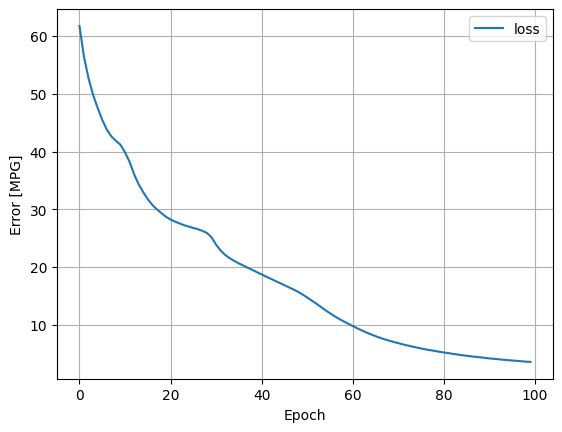

In [60]:
plot_loss(history)

In [55]:
results = model_inverse.evaluate(
    X_test,
    Y_test, 
    verbose=0
)


In [56]:
print(results)

3.519195318222046


In [64]:
model_inverse.save('model_inverse_2joints_64hl.h5')

In [70]:
loaded_model = keras.models.load_model("model_inverse_2joints_64hl.h5")
loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                192       
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                                 
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
_________________________________________________________________
